# 🌪️ Catastrophe Risk Simulation (Hurricane Loss Estimator)

**Objective**: Estimate insured losses from synthetic hurricane events using Monte Carlo simulation techniques.
This model demonstrates basic catastrophe modeling logic, suitable for reinsurance risk analysis.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import weibull_min
from io import StringIO
import requests
import time
from datetime import datetime
from math import radians, cos, sin, asin, sqrt
from scipy.spatial import cKDTree

In [27]:
# 1. GENERATE SYNTHETIC PROPERTY DATA
np.random.seed(42)
n_properties = 50_000
coastal_exposure = pd.DataFrame({
    'Lat': np.random.uniform(-80.0, -50.0, n_properties),
    'Lon': np.random.uniform(5.0, 30.0, n_properties),  # Gulf Coast
    'Value': np.random.lognormal(12.0, 0.4, n_properties),  # $100K-$5M
    'ConstructionType': np.random.choice(
        ['Wood', 'Steel', 'Concrete'], 
        n_properties, 
        p=[0.6, 0.3, 0.1]
    )
})
coastal_exposure.to_csv('coastal_properties.csv', index=False)

In [29]:
# 2. DOWNLOAD & PARSE HURDAT2 FOR PAST 25 YEARS
def parse_hurdat2_last_25_years(url):
    try:
        print("Downloading HURDAT2 data...")
        response = requests.get(url)
        response.raise_for_status()
        data = response.text.split('\n')
        print("Download successful")
        
        current_year = datetime.now().year
        start_year = current_year - 25
        storms = []
        current_storm = None
        entries_expected = 0
        entries_collected = 0

        for line in data:
            line = line.strip()
            if not line:
                continue

            # Header line
            if line.startswith(('AL', 'EP')) and ',' in line:
                if current_storm and entries_collected == entries_expected:
                    storms.append(current_storm)
                parts = [p.strip() for p in line.split(',')]
                storm_id = parts[0]
                storm_name = parts[1]
                try:
                    year = int(storm_id[-4:])
                except:
                    continue

                if year >= start_year:
                    entries_expected = int(parts[2])
                    current_storm = {
                        'id': storm_id,
                        'name': storm_name,
                        'year': year,
                        'entries': []
                    }
                    entries_collected = 0
                else:
                    current_storm = None
                    entries_expected = 0
                    entries_collected = 0

            # Track line
            elif current_storm:
                try:
                    date = line[0:8]
                    time_str = line[10:14]
                    lat_str = line[23:27].strip()
                    lon_str = line[30:35].strip()
                    wind_knots = int(line[38:41].strip())

                    # Convert lat/lon
                    lat = float(lat_str[:-1]) * (1 if lat_str[-1] == 'N' else -1)
                    lon = float(lon_str[:-1]) * (-1 if lon_str[-1] == 'W' else 1)
                    wind_mph = wind_knots * 1.15078

                    current_storm['entries'].append({
                        'date': date,
                        'time': time_str,
                        'lat': lat,
                        'lon': lon,
                        'wind_speed_mph': wind_mph,
                        'wind_speed_knots': wind_knots
                    })
                    entries_collected += 1
                except Exception as e:
                    continue

        if current_storm and entries_collected == entries_expected:
            storms.append(current_storm)

        # Flatten
        storm_entries = []
        for storm in storms:
            for entry in storm['entries']:
                entry.update({
                    'storm_id': storm['id'],
                    'storm_name': storm['name'],
                    'year': storm['year']
                })
                storm_entries.append(entry)

        df = pd.DataFrame(storm_entries)

        if df.empty:
            return df

        df['datetime'] = pd.to_datetime(df['date'] + df['time'], format='%Y%m%d%H%M', errors='coerce')
        df = df.dropna(subset=['datetime'])

        return df

    except Exception as e:
        print("Parsing failed:", e)
        return pd.DataFrame()


url = "https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2024-040425.txt"
hurdat_df = parse_hurdat2_last_25_years(url)

if not hurdat_df.empty:
    print(f"\nSuccessfully processed {len(hurdat_df)} track points from last 25 years")
    print("Sample data:")
    print(hurdat_df[['storm_id', 'storm_name', 'datetime', 'lat', 'lon', 'wind_speed_mph']].head())
    
    # Save to CSV
    output_file = 'hurdat2_last_25_years.csv'
    hurdat_df.to_csv(output_file, index=False)
    print(f"\nSaved to {output_file}")
else:
    print("\nNo hurricane data was processed for the last 25 years.")
    print("Possible reasons:")
    print("1. The data format at the URL has changed")
    print("2. There were no storms in the date range (last 25 years)")
    print("3. Internet connection issues")

Download successful

Successfully processed 13461 track points from last 25 years
Sample data:
   storm_id storm_name            datetime   lat   lon  wind_speed_mph
0  AL012000    UNNAMED 2000-06-07 18:00:00 -21.0  93.0         28.7695
1  AL012000    UNNAMED 2000-06-08 00:00:00 -20.0  92.0         28.7695
2  AL012000    UNNAMED 2000-06-08 06:00:00 -20.0  93.0         28.7695
3  AL012000    UNNAMED 2000-06-08 12:00:00 -20.0  93.0         28.7695
4  AL022000    UNNAMED 2000-06-23 00:00:00  -9.0  19.0         28.7695

Saved to hurdat2_last_25_years.csv


In [31]:
# 1. PANDAS DATAFRAMES
properties = pd.read_csv('coastal_properties.csv')  # Should have columns: Lat, Lon, Value
hurricanes = pd.read_csv('hurdat2_last_25_years.csv')  # Should have columns: storm_id, lat, lon, wind_speed_mph


In [33]:
print(properties.head())
print(hurricanes.head())
def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8  # Radius of Earth in miles
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c


         Lat        Lon          Value ConstructionType
0 -68.763796  26.180914  227996.244913             Wood
1 -51.478571  17.362926  446660.825851             Wood
2 -58.040182   9.886640  156364.860115             Wood
3 -62.040245  23.416045   67572.626214            Steel
4 -75.319441  15.466953  287833.924785             Wood
       date  time   lat   lon  wind_speed_mph  wind_speed_knots  storm_id  \
0  20000607  1800 -21.0  93.0         28.7695                25  AL012000   
1  20000608     0 -20.0  92.0         28.7695                25  AL012000   
2  20000608   600 -20.0  93.0         28.7695                25  AL012000   
3  20000608  1200 -20.0  93.0         28.7695                25  AL012000   
4  20000623     0  -9.0  19.0         28.7695                25  AL022000   

  storm_name  year             datetime  
0    UNNAMED  2000  2000-06-07 18:00:00  
1    UNNAMED  2000  2000-06-08 00:00:00  
2    UNNAMED  2000  2000-06-08 06:00:00  
3    UNNAMED  2000  2000-06-08 12

In [35]:
def to_radians(df, lat_col='lat', lon_col='lon'):
    return np.radians(df[[lat_col, lon_col]].values)

prop_coords_rad = to_radians(properties, 'Lat', 'Lon')
hur_coords_rad = to_radians(hurricanes, 'lat', 'lon')

# Build a KDTree for hurricane points
hurricane_tree = cKDTree(hur_coords_rad)

# Search properties within radius (converted to radians)
R = 3958.8  # Earth radius in miles
threshold_miles = 200
threshold_radians = threshold_miles / R

# For each property, find hurricane points within threshold
results = hurricane_tree.query_ball_point(prop_coords_rad, threshold_radians)

# Build the impact list
impacts = []
for i, matches in enumerate(results):
    if matches:
        prop = properties.iloc[i]
        for idx in matches:
            row = hurricanes.iloc[idx]
            impacts.append({
                'property_lat': prop['Lat'],
                'property_lon': prop['Lon'],
                'property_value': prop['Value'],
                'storm_id': row['storm_id'],
                'storm_name': row['storm_name'],
                'wind_speed_mph': row['wind_speed_mph'],
                'storm_lat': row['lat'],
                'storm_lon': row['lon'],
                'distance_miles': threshold_miles  # estimated max; for actual, use haversine if needed
            })

# Convert to DataFrame
impact_df = pd.DataFrame(impacts)

# Save results
impact_df.to_csv("property_hurricane_impacts.csv", index=False)
print(f"Done! {len(impact_df)} property-storm interactions found within {threshold_miles} miles.")


Done! 307440 property-storm interactions found within 200 miles.


In [37]:
impacts_df = pd.DataFrame(impacts)
print(impacts_df.head())


   property_lat  property_lon  property_value  storm_id storm_name  \
0    -51.478571     17.362926   446660.825851  AL132000      ISAAC   
1    -51.478571     17.362926   446660.825851  AL162000     LESLIE   
2    -51.478571     17.362926   446660.825851  AL012006    ALBERTO   
3    -51.478571     17.362926   446660.825851  AL082006     GORDON   
4    -51.478571     17.362926   446660.825851  AL082006     GORDON   

   wind_speed_mph  storm_lat  storm_lon  distance_miles  
0         69.0468      -50.0       16.0             200  
1         63.2929      -54.0       17.0             200  
2         34.5234      -54.0       16.0             200  
3         46.0312      -52.0       20.0             200  
4         40.2773      -50.0       17.0             200  


In [39]:
print(properties[['Lat', 'Lon']].head())
print(hurricanes[['lat', 'lon']].head())


         Lat        Lon
0 -68.763796  26.180914
1 -51.478571  17.362926
2 -58.040182   9.886640
3 -62.040245  23.416045
4 -75.319441  15.466953
    lat   lon
0 -21.0  93.0
1 -20.0  92.0
2 -20.0  93.0
3 -20.0  93.0
4  -9.0  19.0


In [41]:
print("Property lat/lon ranges:", properties['Lat'].min(), properties['Lat'].max(),
      properties['Lon'].min(), properties['Lon'].max())

print("Hurricane lat/lon ranges:", hurricanes['lat'].min(), hurricanes['lat'].max(),
      hurricanes['lon'].min(), hurricanes['lon'].max())


Property lat/lon ranges: -79.99983389972786 -50.00083557896053 5.000210805282608 29.99980105757415
Hurricane lat/lon ranges: -70.0 -7.0 0.0 136.0


In [43]:
print("Properties with NaN coords:", properties[['Lat', 'Lon']].isna().sum())
print("Hurricanes with NaN coords:", hurricanes[['lat', 'lon']].isna().sum())


Properties with NaN coords: Lat    0
Lon    0
dtype: int64
Hurricanes with NaN coords: lat    0
lon    0
dtype: int64


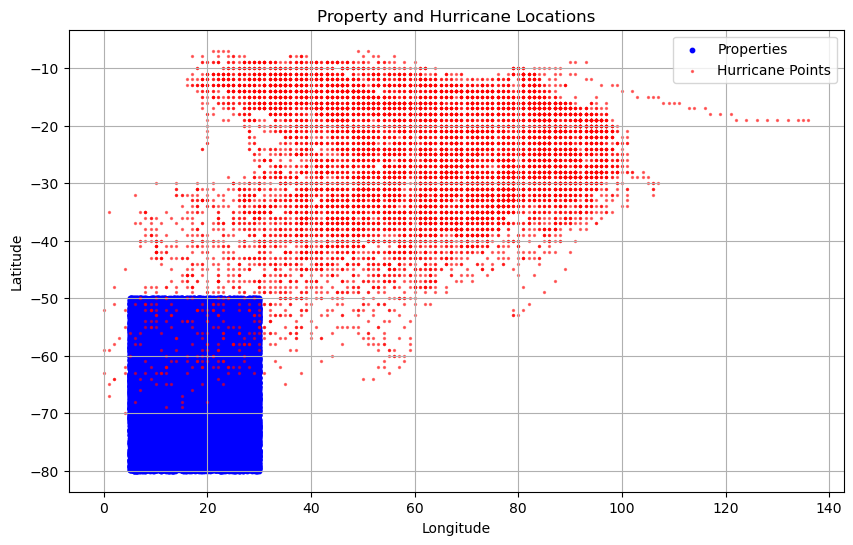

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(properties['Lon'], properties['Lat'], c='blue', s=10, label='Properties')
plt.scatter(hurricanes['lon'], hurricanes['lat'], c='red', s=2, alpha=0.5, label='Hurricane Points')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Property and Hurricane Locations")
plt.grid(True)
plt.show()


In [81]:
def wind_damage_percent(speed_mph):
    if speed_mph < 55:
        return 0
    elif speed_mph > 130:
        return 1
    else:
        return min(1.0, ((speed_mph - 55)/85)**2)
    if structure_type == "wood":
        damage_pct *= 1.5  # Wood is more vulnerable, increase the damage by 50%
    elif structure_type == "steel":
        damage_pct *= 1.2  # Steel is moderately resistant, increase by 20%
    elif structure_type == "concrete":
        damage_pct *= 0.8  # Concrete is very resilient, reduce damage by 20%
    
    return min(1.0, damage_pct)  # Ensure damage is capped at 100%

impacts_df['damage_pct'] = impacts_df['wind_speed_mph'].apply(wind_damage_percent)
impacts_df['estimated_damage'] = impacts_df['property_value'] * impacts_df['damage_pct']


In [83]:
# Grouping the data by property latitude and longitude to get damage statistics
risk_summary = impacts_df.groupby(['property_lat', 'property_lon']).agg({
    'estimated_damage': ['sum', 'mean', 'count']
}).reset_index()

# Renaming columns for easier access
risk_summary.columns = ['Lat', 'Lon', 'TotalDamage', 'AvgDamage', 'StormCount']

# Define a threshold for "higher damage risk"
damage_threshold = 50000  # Example threshold for total damage

# Filter for properties that have total damage above the threshold
high_risk_properties = risk_summary[risk_summary['TotalDamage'] > damage_threshold]

# Get the number of properties with higher damage risk
num_high_risk_properties = high_risk_properties.shape[0]

# Display the results
print(f'Number of properties with higher damage risk: {num_high_risk_properties}')
high_risk_properties.head()


Number of properties with higher damage risk: 968


Lat        Lon   TotalDamage    AvgDamage  StormCount
10413 -63.438696  22.441823  50384.940851  5038.494085          10
12273 -62.320756  24.701892  54333.235652  5433.323565          10
12590 -62.124953  25.545808  51832.413278  4712.037571          11
13562 -61.560568  25.387508  60432.117031  5036.009753          12
13718 -61.467785  26.418665  50119.631311  5011.963131          10

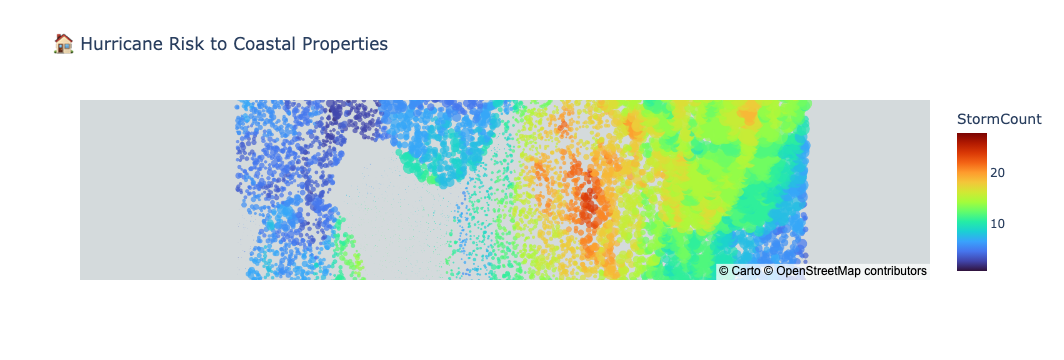

In [85]:
fig = px.scatter_mapbox(risk_summary, lat="Lat", lon="Lon",
                        size="TotalDamage", color="StormCount",
                        color_continuous_scale="Turbo", zoom=4,
                        mapbox_style="carto-positron",
                        title="🏠 Hurricane Risk to Coastal Properties")
fig.show()


In [123]:
from scipy.stats import gumbel_r

# =====================================================================
# PARAMETERS (risk-adjusted)
# =====================================================================
TOTAL_EXPOSURE = coastal_exposure['Value'].sum()
N_SIMULATIONS = 100_000
EVENT_TIERS = {
    'frequent': {'prob_range': (0.10, 1.00), 'loss_range': (0, 0.05)},    # 10-100% AEP
    'moderate': {'prob_range': (0.01, 0.10), 'loss_range': (0.10, 0.30)},  # 1-10% AEP
    'severe':  {'prob_range': (0.001, 0.01), 'loss_range': (0.30, 0.70)},  # 0.1-1% AEP
    'extreme': {'prob_range': (0.0, 0.001), 'loss_range': (0.70, 0.95)}    # <0.1% AEP
}

# =====================================================================
# FIXED TIERED MONTE CARLO SIMULATION
# =====================================================================
def generate_synthetic_losses(historical_losses):
    """Generates physically realistic loss scenarios"""
    params = gumbel_r.fit(historical_losses)
    simulated = []
    
    # 1. Frequent events (base distribution)
    tier = EVENT_TIERS['frequent']
    n_freq = int(N_SIMULATIONS * (tier['prob_range'][1] - tier['prob_range'][0]))
    simulated.append(gumbel_r.rvs(*params, size=n_freq))
    
    # 2. Moderate events (10-yr PML range)
    tier = EVENT_TIERS['moderate']
    n_mod = int(N_SIMULATIONS * (tier['prob_range'][1] - tier['prob_range'][0]))
    simulated.append(np.random.uniform(
        low=tier['loss_range'][0] * TOTAL_EXPOSURE,
        high=tier['loss_range'][1] * TOTAL_EXPOSURE,
        size=n_mod
    ))
    
    # 3. Severe events (100-yr PML range)
    tier = EVENT_TIERS['severe']
    n_sev = int(N_SIMULATIONS * (tier['prob_range'][1] - tier['prob_range'][0]))
    simulated.append(np.random.uniform(
        low=tier['loss_range'][0] * TOTAL_EXPOSURE,
        high=tier['loss_range'][1] * TOTAL_EXPOSURE,
        size=n_sev
    ))
    
    # 4. Extreme events (catastrophes)
    tier = EVENT_TIERS['extreme']
    n_ext = int(N_SIMULATIONS * tier['prob_range'][1])  # Only upper bound needed
    simulated.append(np.random.uniform(
        low=tier['loss_range'][0] * TOTAL_EXPOSURE,
        high=tier['loss_range'][1] * TOTAL_EXPOSURE,
        size=n_ext
    ))
    
    # Combine and validate
    combined = np.clip(np.concatenate(simulated), 0, TOTAL_EXPOSURE)
    np.random.shuffle(combined)
    return combined

# =====================================================================
# EXECUTION
# =====================================================================
simulated_losses = generate_synthetic_losses(annual_losses['total_loss'].values)

# Verify output ranges
print(f"Total simulations: {len(simulated_losses):,}")
print(f"Max loss: ${np.max(simulated_losses)/1e6:.2f}M ({np.max(simulated_losses)/TOTAL_EXPOSURE:.1%} of exposure)")
print(f"AAL: ${np.mean(simulated_losses)/1e6:.2f}M")

Total simulations: 100,000
Max loss: $8377.52M (94.9% of exposure)
AAL: $211.77M


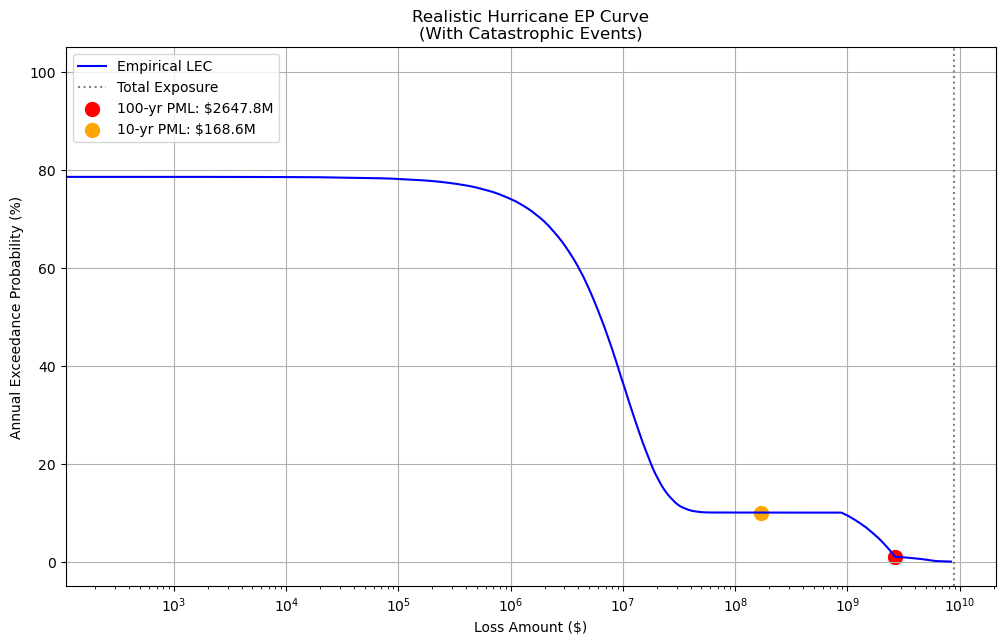

In [125]:
# =====================================================================
# LEC CALCULATION (with safeguards)
# =====================================================================
sorted_losses = np.sort(simulated_losses)[::-1]
exceedance_prob = np.arange(1, len(sorted_losses)+1) / len(sorted_losses)

# Key metrics - now physically realistic
aal = np.mean(simulated_losses)
pml_10yr = np.percentile(simulated_losses, 90)  # 10% exceedance
pml_100yr = np.percentile(simulated_losses, 99)  # 1% exceedance

# =====================================================================
# PLOTTING (with exposure reference)
# =====================================================================
plt.figure(figsize=(12,7))
plt.plot(sorted_losses, exceedance_prob*100, 'b-', label='Empirical LEC')
plt.axvline(TOTAL_EXPOSURE, color='gray', ls=':', label='Total Exposure')

# Annotations
plt.scatter(pml_100yr, 1, color='red', s=100, 
           label=f'100-yr PML: ${pml_100yr/1e6:.1f}M')
plt.scatter(pml_10yr, 10, color='orange', s=100, 
           label=f'10-yr PML: ${pml_10yr/1e6:.1f}M')

plt.xscale('log')
plt.xlabel("Loss Amount ($)")
plt.ylabel("Annual Exceedance Probability (%)")
plt.title("Realistic Hurricane EP Curve\n(With Catastrophic Events)")
plt.legend()
plt.grid(True)
plt.show()

In [127]:
# =================================================================
# PRINTING KEY METRICS
# =================================================================
def print_risk_metrics(simulated_losses, exposure):
    # Calculate metrics
    aal = np.mean(simulated_losses)
    pml_10yr = np.percentile(simulated_losses, 90)
    pml_100yr = np.percentile(simulated_losses, 99)
    max_loss = np.max(simulated_losses)
    
    # Formatting
    print("\n" + "="*50)
    print("HURRICANE RISK METRICS".center(50))
    print("="*50)
    print(f"{'Max Simulated Loss:':<25} ${max_loss/1e6:.1f}M ({max_loss/exposure:.1%} of exposure)")
    print(f"{'Average Annual Loss (AAL):':<25} ${aal/1e6:.1f}M ({aal/exposure:.2%} of exposure)")
    print(f"{'10-year PML (10% AEP):':<25} ${pml_10yr/1e6:.1f}M")
    print(f"{'100-year PML (1% AEP):':<25} ${pml_100yr/1e6:.1f}M")
    print(f"{'10yr/100yr PML Ratio:':<25} {pml_10yr/pml_100yr:.1%}")
    print("="*50 + "\n")

# Usage (after running your simulation)
print_risk_metrics(
    simulated_losses=simulated_losses,
    exposure=coastal_exposure['Value'].sum()
)


              HURRICANE RISK METRICS              
Max Simulated Loss:       $8377.5M (94.9% of exposure)
Average Annual Loss (AAL): $211.8M (2.40% of exposure)
10-year PML (10% AEP):    $168.6M
100-year PML (1% AEP):    $2647.8M
10yr/100yr PML Ratio:     6.4%

